In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.spatial import distance as dist
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse

import physipy

%matplotlib inline

In [2]:
# Global variables
CELL_RADIUS = 8
VARIABLES = ['ID', 'position_x', 'position_y', 'position_z']
BASE_FOLDER = Path('output')   

In [4]:
timestep = 4
cells = physipy.get_cell_data(timestep, BASE_FOLDER, VARIABLES)
cell_df = pd.DataFrame(cells)
cell_df

ID  position_x  position_y  position_z
0      0.0 -346.160440  207.192325  -59.112326
1      1.0 -296.878373  264.637496  -66.126060
2      2.0 -376.833269  167.207522  -82.292221
3      3.0 -268.047896  155.479298  -87.408765
4      4.0 -186.825995  229.325957  -66.437145
..     ...         ...         ...         ...
228  230.0  -11.412105  219.221833   25.136198
229  231.0  177.430033   35.904806  -71.049081
230  232.0    1.149001   52.213154   40.892127
231  233.0 -197.526219   83.505263    5.923068
232  234.0 -157.308898  140.555094   -5.526300

[233 rows x 4 columns]

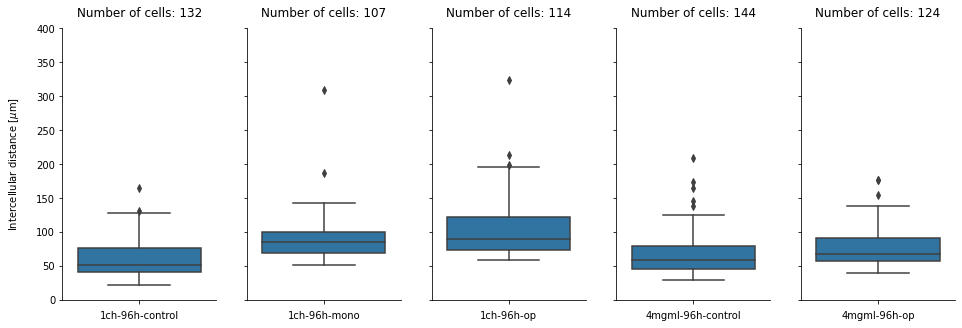

In [155]:
def compute_distance(cells, id1, id2):
    cell1 = cells[cells['ID'] == id1]
    pos1 = (cell1['position_x'], cell1['position_y'])
    cell2 = cells[cells['ID'] == id2]
    pos2 = (cell2['position_x'], cell2['position_y'])
    
    distance = dist.euclidean(pos1, pos2)
    
    return distance

def get_pair(i, j):
    if i < j:
        pair = (i, j)
    else: 
        pair = (j, i)
        
    return pair

number_of_neighbors = 5
timestep = 4

BASE_FOLDER = Path('dist-data')  

conditions = ['1ch-96h-control', '1ch-96h-mono', '1ch-96h-op', '4mgml-96h-control',
              '4mgml-96h-op']

fig, axes = plt.subplots(1, 5, sharey=True, figsize=(16, 5))

for j, condition in enumerate(conditions):
    cells_list = []
    for replicate in range(1, 3):
        cells = physipy.get_cell_data(timestep, BASE_FOLDER / condition / f'replicate{replicate}', VARIABLES)
        rep_df = pd.DataFrame(cells)
        rep_df['replicate'] = replicate
        cells_list.append(rep_df)
        
    cell_df = pd.concat(cells_list)
    cell_df = cell_df[cell_df['position_z'].between(-20, 20)]
    
    for replicate in range(1, 3):
        distance_pairs = {}
        day_dist = {}
        average_distance = []
        rep_cells = cell_df[cell_df['replicate'] == replicate]
        for current_cell in rep_cells['ID'].unique():
            distances = []
            for i in rep_cells['ID'].unique():
                if i != current_cell:
                    pair = get_pair(i, current_cell)
                    if pair not in distance_pairs.keys():
                        distance = compute_distance(rep_cells, current_cell, i)
                        distances.append(distance)
                        distance_pairs[pair] = distance
                    else:
                        distances.append(distance_pairs[pair])

            smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
            average_neighborhood = smallest_distances.mean()

            average_distance.append(average_neighborhood)

    day_dist[timestep] = average_distance
    
    sns.boxplot(data=pd.DataFrame(day_dist).melt(), x='variable', y='value', ax=axes[j])
    
    axes[j].set_ylim(0, 400)
    if j == 0:
        axes[j].set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
    else:
        axes[j].set_ylabel('')
        
    axes[j].set_title(f'Number of cells: {cell_df["ID"].size}', y=1.02)
        
    axes[j].set_xlabel(condition)
    axes[j].set_xticklabels([])
    
sns.despine()
#plt.savefig('/home/ines/writing/pdgf_paper/hapto_figures/raw-dist.png')

In [158]:
number_of_neighbors = 5
timestep = 4
all_conditions = []

BASE_FOLDER = Path('dist-data')  

conditions = ['1ch-96h-control', '1ch-96h-mono', '1ch-96h-op',
              '4mgml-96h-control', '4mgml-96h-op']

for j, condition in enumerate(conditions):
    distance_pairs = {}
    day_dist = {}
    average_distance = []
    cells_list = []
    for replicate in range(1, 3):
        cells = physipy.get_cell_data(timestep, BASE_FOLDER / condition / f'replicate{replicate}', VARIABLES)
        rep_df = pd.DataFrame(cells)
        rep_df['replicate'] = replicate
        rep_df['condition'] = condition
        if condition.find('4mgml') != -1:
            rep_df['Density'] = '4 mg/mL'
        else:
            rep_df['Density'] = '2.5 mg/mL'
        if condition.find('control') != -1:
            rep_df['PDGF Placement'] = 'Control'
        else:
            if condition.find('mono') != -1:
                rep_df['PDGF Placement'] = 'Cell chamber'
            else:
                rep_df['PDGF Placement'] = 'Opposite chamber'
        cells_list.append(rep_df)
        rep_df = rep_df[rep_df['position_z'].between(-40, 40)]
        
    cell_df = pd.concat(cells_list)
    cell_df = cell_df.sample(100)
    all_conditions.append(cell_df)
    
cells_df = pd.concat(all_conditions)

cells_df = cells_df.reset_index(drop=True)
cells_df

ID  position_x  position_y  position_z  replicate        condition  \
0    234.0  376.407346  251.914914   36.980653          2  1ch-96h-control   
1     13.0  164.108744  232.191607 -103.056302          2  1ch-96h-control   
2    141.0   57.733372   85.833113   -2.281203          2  1ch-96h-control   
3      7.0 -115.354508  286.589623  -52.681227          1  1ch-96h-control   
4    154.0 -263.264439   72.478568   -2.580342          2  1ch-96h-control   
..     ...         ...         ...         ...        ...              ...   
495  146.0  179.388063  132.782812  -18.690277          1     4mgml-96h-op   
496  187.0  106.871863  379.928179  -63.570323          1     4mgml-96h-op   
497  187.0  -29.080040  241.732552   -6.216460          2     4mgml-96h-op   
498   51.0 -203.314735  461.858989    6.170831          2     4mgml-96h-op   
499  233.0  149.816256  272.064227  -48.496052          1     4mgml-96h-op   

       Density    PDGF Placement  
0    2.5 mg/mL           Control  
1    2.5 mg/mL           Control  
2    2.5 mg/mL           Control  
3    2.5 mg/mL           Control  
4    2.5 mg/mL           Control  
..         ...               ...  
495    4 mg/mL  Opposite chamber  
496    4 mg/mL  Opposite chamber  
497    4 mg/mL  Opposite chamber  
498    4 mg/mL  Opposite chamber  
499    4 mg/mL  Opposite chamber  

[500 rows x 8 columns]

In [107]:
'4mgml'.find('2')

-1

In [159]:
cells_df['dist_to_neighbors'] = np.nan

for j, condition in enumerate(conditions):
    condition_df = cells_df[cells_df['condition'] == condition]
    
    for replicate in range(1, 3):
        distance_pairs = {}
        day_dist = {}
        rep_cells = condition_df[condition_df['replicate'] == replicate]
        for current_cell in rep_cells['ID'].unique():
            cell_index = cells_df[(cells_df['replicate'] == replicate) &
                                  (cells_df['ID'] == current_cell) &
                                  (cells_df['condition'] == condition)].index
            distances = []
            for i in rep_cells['ID'].unique():
                if i != current_cell:
                    pair = get_pair(i, current_cell)
                    if pair not in distance_pairs.keys():
                        distance = compute_distance(rep_cells, current_cell, i)
                        distances.append(distance)
                        distance_pairs[pair] = distance
                    else:
                        distances.append(distance_pairs[pair])
            smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
            average_neighborhood = smallest_distances.mean()
            cells_df.loc[cell_index, 'dist_to_neighbors'] = average_neighborhood

<AxesSubplot:xlabel='Density', ylabel='dist_to_neighbors'>

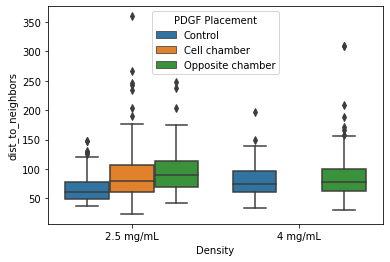

In [160]:
sns.boxplot(data=cells_df, x='Density', y='dist_to_neighbors', hue='PDGF Placement')

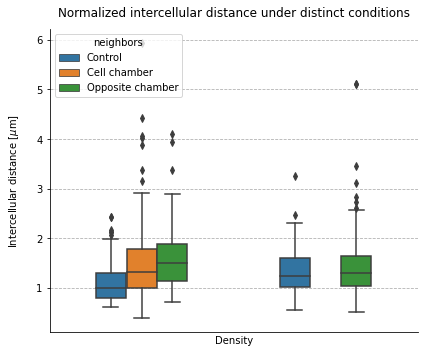

In [166]:
fig, ax = plt.subplots(figsize=(6, 5))
norm_value = cells_df[(cells_df['PDGF Placement'] == 'Control') & 
                       (cells_df['Density'] == '2.5 mg/mL')]['dist_to_neighbors'].median()

cells_df['norm_distance'] = cells_df['dist_to_neighbors']/norm_value
sns.boxplot(data=cells_df, x='Density', y='norm_distance', hue='PDGF Placement', ax=ax, width=0.5)

ax.legend(loc='upper left', title='neighbors')
ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_title('Normalized intercellular distance under distinct conditions', y=1.02)
ax.set_xticks([])
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
sns.despine()
plt.tight_layout()

In [ ]:
for j, condition in enumerate(['1ch-96h-control', '1ch-96h-mono', '1ch-96h-op']):
    distance_pairs = {}
    day_dist = {}
    average_distance = []
    cells_list = []
    for replicate in range(1, 3):
        cells = physipy.get_cell_data(timestep, BASE_FOLDER / condition / f'replicate{replicate}', VARIABLES)
        rep_df = pd.DataFrame(cells)
        rep_df['replicate'] = replicate
        cells_list.append(rep_df)
        
    cell_df = pd.concat(cells_list)
    cell_df = cell_df[cell_df['position_z'].between(-30, 30)]
    
    for replicate in range(1, 3):
        rep_cells = cell_df[cell_df['replicate'] == replicate]
        for current_cell in rep_cells['ID'].unique():
            distances = []
            for i in rep_cells['ID'].unique():
                if i != current_cell:
                    pair = get_pair(i, current_cell)
                    if pair not in distance_pairs.keys():
                        distance = compute_distance(rep_cells, current_cell, i)
                        distances.append(distance)
                        distance_pairs[pair] = distance
                    else:
                        distances.append(distance_pairs[pair])

            smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
            average_neighborhood = smallest_distances.mean()

            average_distance.append(average_neighborhood)

    day_dist[timestep] = average_distance

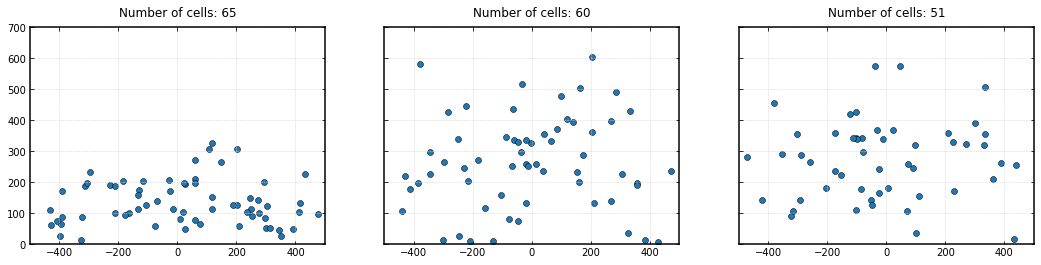

In [22]:
timestep = 4
BASE_FOLDER = Path('dist-data')  
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True, sharex=True)

conditions = ['1ch-96h-control', '1ch-96h-mono', '1ch-96h-op']
for condition, ax in zip(conditions, axes):
    cells = physipy.get_cell_data(timestep, BASE_FOLDER / condition, VARIABLES)
    cell_df = pd.DataFrame(cells)
    cell_df = cell_df[cell_df['position_z'].between(-20, 20)]

    # All cels
    ax.scatter(cell_df['position_x'], cell_df['position_y'], 
                    edgecolor='black', linewidth=0.5)

    ax.set_title(f'Number of cells: {cell_df["ID"].size}', y=1.02)

    ax.set_ylim(0, 700)
    ax.set_xlim(-500,500)

    # Grid
    ax.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)
    ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)

    # Ticks
    ax.tick_params(axis="y", direction="in", right=True)
    ax.tick_params(axis="x", direction="in", top=True)

    # Spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')
        
#plt.savefig('/home/ines/writing/pdgf_paper/hapto_figures/cells.png')

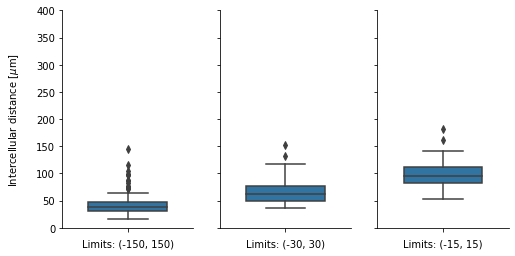

In [196]:
number_of_neighbors = 10
timestep = 4 
limits = [(-150, 150), (-30, 30), (-15, 15)]
condition = '1ch-96h-control'

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharey=True, sharex=True)

for j, limit in enumerate(limits):
    
    day_dist = {}
    average_distance = []
    cells = phypy.get_cell_data(timestep, BASE_FOLDER / condition, VARIABLES)
    cell_df = pd.DataFrame(cells)
    cell_df = cell_df[cell_df['position_z'].between(limit[0], limit[1])]

    for current_cell in cell_df['ID'].unique():
        distances = []
        for i in cell_df['ID'].unique():
            if i != current_cell:
                distance = compute_distance(cell_df, current_cell, i)
                distances.append(distance)

        smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
        average_neighborhood = smallest_distances.mean()

        average_distance.append(average_neighborhood)

    day_dist[timestep] = average_distance

    sns.boxplot(data=pd.DataFrame(day_dist).melt(), x='variable', y='value', ax=axes[j], width=0.6)
    
    axes[j].set_ylim(0, 400)
    if j == 0:
        axes[j].set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
    else:
        axes[j].set_ylabel('')
        
    axes[j].set_xlabel(f'Limits: ({limit[0]}, {limit[1]})')
    axes[j].set_xticklabels([])
    
sns.despine()
plt.savefig('/home/ines/writing/pdgf_paper/hapto_figures/control-dist.png')

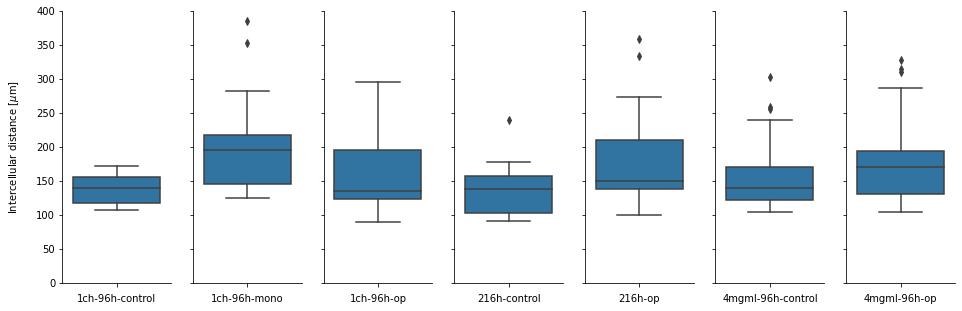

In [214]:
number_of_neighbors = 10
timestep = 4

BASE_FOLDER = Path('dist-data')  

conditions = ['1ch-96h-control', '1ch-96h-mono', '1ch-96h-op', '216h-control', '216h-op',
              '4mgml-96h-control', '4mgml-96h-op']

fig, axes = plt.subplots(1, 7, sharey=True, figsize=(16, 5))

for j, condition in enumerate(conditions):
    if (j < 3) | (j > 4):
        timestep = 4
    else:
        timestep = 9
    distance_pairs = {}
    day_dist = {}
    average_distance = []
    cells = phypy.get_cell_data(timestep, BASE_FOLDER / condition, VARIABLES)
    cell_df = pd.DataFrame(cells)
    cell_df = cell_df[cell_df['position_z'].between(-15,15)].sample(30)

    for current_cell in cell_df['ID'].unique():
        distances = []
        for i in cell_df['ID'].unique():
            if i != current_cell:
                pair = get_pair(i, current_cell)
                if pair not in distance_pairs.keys():
                    distance = compute_distance(cell_df, current_cell, i)
                    distances.append(distance)
                    distance_pairs[pair] = distance
                else:
                    distances.append(distance_pairs[pair])

        smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
        average_neighborhood = smallest_distances.mean()

        average_distance.append(average_neighborhood)

    day_dist[timestep] = average_distance
    
    sns.boxplot(data=pd.DataFrame(day_dist).melt(), x='variable', y='value', ax=axes[j])
    
    axes[j].set_ylim(0, 400)
    if j == 0:
        axes[j].set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
    else:
        axes[j].set_ylabel('')
        
    axes[j].set_xlabel(condition)
    axes[j].set_xticklabels([])
    
sns.despine()
plt.savefig('/home/ines/writing/pdgf_paper/hapto_figures/fixed-dist.png')

In [210]:
cell_df['ID'].size

44

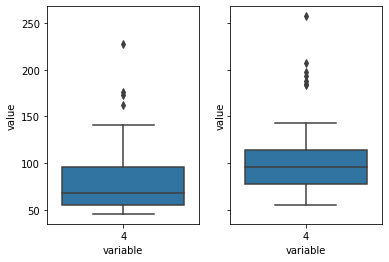

In [172]:
conditions = ['4mgml-96h-control', '4mgml-96h-op']

fig, axes = plt.subplots(1, 2, sharey=True)

for j, condition in enumerate(conditions):
    day_dist = {}
    average_distance = []
    cells = phypy.get_cell_data(timestep, BASE_FOLDER / condition, VARIABLES)
    cell_df = pd.DataFrame(cells)
    cell_df = cell_df[cell_df['position_z'].between(-15, 15)]

    for current_cell in cell_df['ID'].unique():
        distances = []
        for i in cell_df['ID'].unique():
            if i != current_cell:
                distance = compute_distance(cell_df, current_cell, i)
                distances.append(distance)

        smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
        average_neighborhood = smallest_distances.mean()

        average_distance.append(average_neighborhood)

    day_dist[timestep] = average_distance
    
    sns.boxplot(data=pd.DataFrame(day_dist).melt(), x='variable', y='value', ax=axes[j])

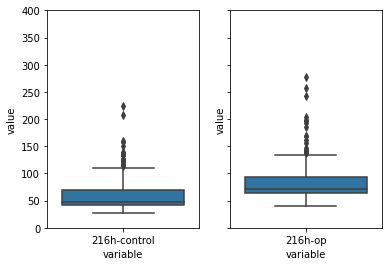

In [177]:
timestep = 9
conditions = ['216h-control', '216h-op']
number_of_neighbors = 10

fig, axes = plt.subplots(1, 2, sharey=True)

for j, condition in enumerate(conditions):
    day_dist = {}
    distance_pairs = {}
    average_distance = []
    cells = phypy.get_cell_data(timestep, BASE_FOLDER / condition, VARIABLES)
    cell_df = pd.DataFrame(cells)
    cell_df = cell_df[cell_df['position_z'].between(-15,15)].sample(n=200)

    for current_cell in cell_df['ID'].unique():
        distances = []
        for i in cell_df['ID'].unique():
            if i != current_cell:
                pair = get_pair(i, current_cell)
                if pair not in distance_pairs.keys():
                    distance = compute_distance(cell_df, current_cell, i)
                    distances.append(distance)
                    distance_pairs[pair] = distance
                else:
                    distances.append(distance_pairs[pair])

        smallest_distances = np.sort(np.array(distances))[:number_of_neighbors]
        average_neighborhood = smallest_distances.mean()

        average_distance.append(average_neighborhood)

    day_dist[condition] = average_distance
    
    sns.boxplot(data=pd.DataFrame(day_dist).melt(), x='variable', y='value', ax=axes[j])
    axes[j].set_ylim(0, 400)

In [97]:
mat_file = sio.loadmat('experimental/experimental_data/joined_results.mat')
for i in mat_file['__function_workspace__'][0]:
    print(i)

0
1
73
77
0
0
0
0
14
0
0
0
152
242
111
2
6
0
0
0
8
0
0
0
2
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
5
0
4
0
5
0
0
0
1
0
0
0
5
0
0
0
77
67
79
83
0
0
0
0
14
0
0
0
80
242
111
2
6
0
0
0
8
0
0
0
17
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
4
0
77
67
79
83
1
0
0
0
13
0
0
0
70
105
108
101
87
114
97
112
112
101
114
95
95
0
0
0
14
0
0
0
16
242
111
2
6
0
0
0
8
0
0
0
1
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
11
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
14
0
0
0
80
1
0
0
6
0
0
0
8
0
0
0
9
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
32
1
0
0
1
0
0
0
1
0
0
0
0
0
0
0
2
0
0
0
32
1
0
0
3
0
0
0
8
0
0
0
96
0
0
0
128
0
0
0
128
0
0
0
176
0
0
0
16
1
0
0
32
1
0
0
0
0
0
0
0
0
0
0
100
97
116
97
0
110
100
105
109
115
0
110
114
111
119
115
0
114
111
119
110
97
109
101
115
0
110
118
97
114
115
0
118
97
114
110
97
109
101
115
0
112
114
111
112
115
0
116
97
98
108
101
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0


1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52


0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104


116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0


0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
5

50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0


0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50

0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
1

8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109

0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
1

52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0

52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0

52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0

0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115

50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0


0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50


0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0


0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116


111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0


5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
9

50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0

108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0

0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0


0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27

0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103

104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1


0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103

0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
4

0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49


0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27

0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27

97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80

0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111


0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50

0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0


0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105

8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109

0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
1

109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0

14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0

120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0

0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115

0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0


53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0


27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45


0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
1

0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
1

0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
1

0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14


0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53

115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0

8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109

16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104

0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0


0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
1

0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
1

0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14


0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16


0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97


0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
11

111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0


109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0

0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
11

8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
11

0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103

104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0

0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45


0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95


5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
9

0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
1

120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0

0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49


0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112


0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49


0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
1

0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0


0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0


8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109

49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27

8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
11

0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
1

0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97

99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0


0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112


0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116


104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0


0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49


0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
5

50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0

0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45


0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
1

0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52

0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116


0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111


105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0

0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0


0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
11

52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0

0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
5

53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0


112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0


49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27

0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
5

16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104

0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
5

45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0

52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0


5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
9

112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0


0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0


0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53

0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0


45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0

0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103

0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
5

0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53

109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0

0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
1

0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0


0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116


97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80

45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0

0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
11

111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0


112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0


109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0

97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0


1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109

0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50

5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
9

0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0


105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0

0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
1

0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95


95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5

45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0

0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0


0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52

0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0


4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120

108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0

50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0


0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16


0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53

0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45

0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95


120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0

0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
1

50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0

27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0


104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1


0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103

0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52

0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52

120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0
4
0
0
0
0
0
0
0
5
0
0
0
8
0
0
0
1
0
0
0
27
0
0
0
1
0
0
0
0
0
0
0
16
0
0
0
27
0
0
0
104
97
112
116
111
116
97
120
105
115
45
50
95
53
109
103
109
108
45
49
52
52
104
45
50
99
104
0
0
0
0
0
14
0
0
0
80
0
0
0
6
0
0
0
8
0
0
0

KeyboardInterrupt: 